In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, Embedding
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from gc import callbacks
import os
from tensorflow import keras
from keras.models import Sequential, load_model

In [2]:
drive.mount('/content/drive')

X_train = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/X_train.csv', delimiter=',')
X_val =  np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/X_val.csv', delimiter=',')
X_test =  np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/X_test.csv', delimiter=',')

Y_train = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/Y_train.csv', delimiter=',')
Y_val = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/Y_val.csv', delimiter=',')
Y_test = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/Y_test.csv', delimiter=',')

print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

Mounted at /content/drive
(291, 47) (291, 3)
(98, 47) (98, 3)
(130, 47) (130, 3)


remove neutral values - make a binary classification

In [3]:
binary_Y_train = []
binary_X_train = []

for index in range(Y_train.shape[0]):
  if Y_train[index][1] != 1:
    binary_Y_train.append(Y_train[index])
    binary_X_train.append(X_train[index])


binary_X_val = []
binary_Y_val = []

for index in range(Y_val.shape[0]):
  if Y_val[index][1] != 1:
    binary_Y_val.append(Y_val[index])
    binary_X_val.append(X_val[index])

binary_X_test = []
binary_Y_test = []

for index in range(Y_test.shape[0]):
  if Y_test[index][1] != 1:
    binary_Y_test.append(Y_test[index])
    binary_X_test.append(X_test[index])


In [4]:
Y_train = np.array(binary_Y_train)
X_train = np.array(binary_X_train)

Y_val = np.array(binary_Y_val)
X_val = np.array(binary_X_val)

Y_test = np.array(binary_Y_test)
X_test = np.array(binary_X_test)


print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(262, 47) (262, 3)
(88, 47) (88, 3)
(117, 47) (117, 3)


In [11]:
checkpoint_path = "/content/drive/My Drive/thesis/code/binary_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

def fit(classifier,epochs, batch_size,monitor = 'val_loss', verbose = 'auto'):
  history = classifier.fit(
    x = X_train, 
    y = Y_train, 
    epochs=epochs, 
    shuffle = False,
    batch_size=batch_size,
    validation_data=(X_val, Y_val),
    verbose = verbose,
    callbacks=[ModelCheckpoint(filepath=checkpoint_path, monitor=monitor,mode='max',save_best_only=True)]
    )
  return history

def evaluate(classifier):
  accr = classifier.evaluate(X_test,Y_test)
  print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
  return accr

def plot(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

  plt.title('accuracy')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.legend()
  plt.show()

In [8]:
def draw_confusion_matrix(y_predict):
  "gets the one-hot-encoded y_predict and draw confusion matrix for y_test and y_predict"
  y_pred = [np.where(r==1)[0][0] for r in y_predict]
  y_test = [np.where(r==1)[0][0] for r in Y_test]

  confusion = confusion_matrix(y_test, y_pred)
  # print('Confusion Matrix\n')
  # print(confusion)

  ax = sns.heatmap(confusion/np.sum(confusion), annot=True, cmap='Blues')
  ax.set_xlabel('\nPredicted sentiment Category')
  ax.set_ylabel('Actual senntiment Category ');
  ax.xaxis.set_ticklabels(['negative', 'positive'])
  ax.yaxis.set_ticklabels(['negative', 'positive'])

  plt.show()

In [9]:
initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')

In [27]:
classifier = Sequential()
classifier.add(Embedding(332, 64, input_length = X_train.shape[1]))
classifier.add(Dropout(0.4))
classifier.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
classifier.add(Dropout(0.4))
classifier.add(Dense(32))
classifier.add(Dropout(0.4))
classifier.add(Dense(3, activation='sigmoid', bias_initializer=initializer)) 
classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])  

epochs = 50
batch_size = 128
history = fit(classifier, epochs, batch_size, 'val_accuracy',  0)

In [28]:
print("best train accuracy : " , history.history['accuracy'][np.argmax(history.history['accuracy'])], "in epoch : ",np.argmax(history.history['accuracy']))
print("best validation accuracy : " , history.history['val_accuracy'][np.argmax(history.history['val_accuracy'])], "in epoch : ",np.argmax(history.history['val_accuracy']))

best train accuracy :  0.9503816962242126 in epoch :  47
best validation accuracy :  0.8068181872367859 in epoch :  49


In [29]:
best_cassifier = load_model(checkpoint_path)

In [30]:
evaluate(best_cassifier)

4/4 [==============================] - 0s 12ms/step - loss: 0.3484 - accuracy: 0.8120
Test set
  Loss: 0.348
  Accuracy: 0.812


[0.3484005033969879, 0.811965823173523]

# Analisys

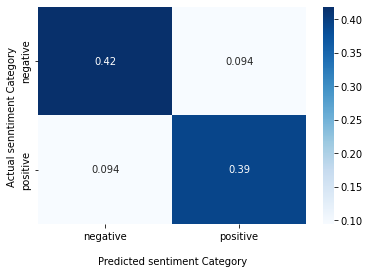

In [31]:
Y_predict = classifier.predict(X_test)
Y_predict = to_categorical(np.argmax(Y_predict, axis=1),3)
draw_confusion_matrix(Y_predict)

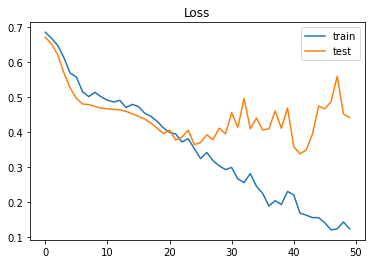

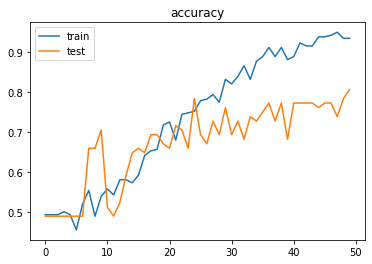

In [32]:
plot(history)

In [33]:
from sklearn.metrics import classification_report

target_names = ["negative" , "neutral" , "positive"]

print(classification_report(Y_test, Y_predict, target_names = target_names))

              precision    recall  f1-score   support

    negative       0.82      0.82      0.82        60
     neutral       0.00      0.00      0.00         0
    positive       0.81      0.81      0.81        57

   micro avg       0.81      0.81      0.81       117
   macro avg       0.54      0.54      0.54       117
weighted avg       0.81      0.81      0.81       117
 samples avg       0.81      0.81      0.81       117



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
